Using device: cuda
Processing folder: /home/khare.aks/Dataset/combined/COVID/COVID
Processing folder: /home/khare.aks/Dataset/combined/NORMAL/NORMAL
Processing folder: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA
Processing folder: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis
Classes and their indices: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'Tuberculosis': 3}
Number of classes: 4
Epoch 1/20
Train Loss: 0.2808, Train Acc: 0.8980
Val Loss: 0.1399, Val Acc: 0.9556
Epoch 2/20
Train Loss: 0.1560, Train Acc: 0.9461
Val Loss: 0.2935, Val Acc: 0.9298
Epoch 3/20
Train Loss: 0.1299, Train Acc: 0.9544
Val Loss: 0.1296, Val Acc: 0.9556
Epoch 4/20
Train Loss: 0.1050, Train Acc: 0.9656
Val Loss: 0.0961, Val Acc: 0.9700
Epoch 5/20
Train Loss: 0.0955, Train Acc: 0.9663
Val Loss: 0.1099, Val Acc: 0.9610
Epoch 6/20
Train Loss: 0.0494, Train Acc: 0.9838
Val Loss: 0.0845, Val Acc: 0.9766
Epoch 7/20
Train Loss: 0.0403, Train Acc: 0.9859
Val Loss: 0.0748, Val Acc: 0.9784
Epoch 8/20


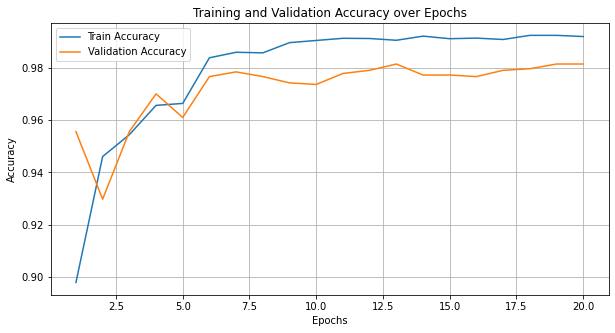


Classification Report:
              precision    recall  f1-score   support

       COVID       0.97      0.97      0.97       154
      NORMAL       0.98      0.98      0.98       919
   PNEUMONIA       0.97      0.98      0.98       414
Tuberculosis       0.96      0.93      0.95       179

    accuracy                           0.98      1666
   macro avg       0.97      0.97      0.97      1666
weighted avg       0.98      0.98      0.98      1666



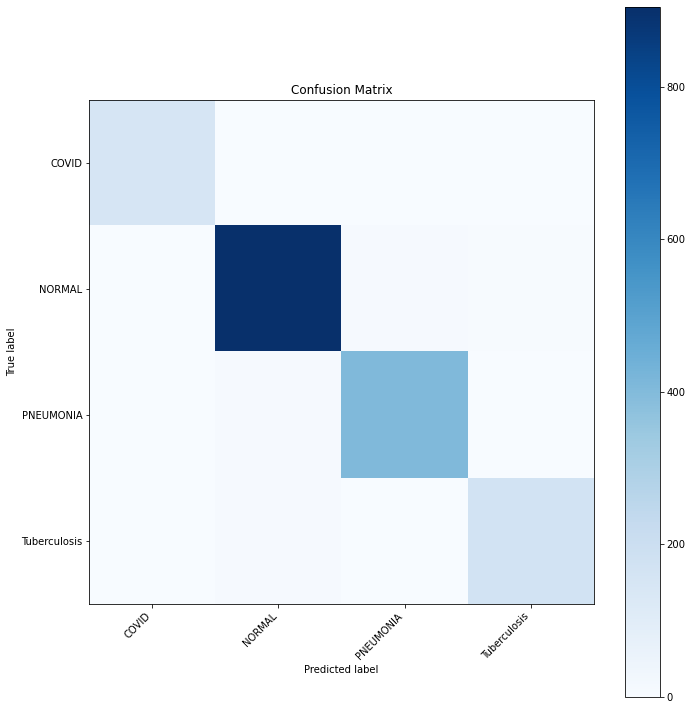

Test Accuracy: 0.9754

Sample Validation Predictions:
Sample 1: True: PNEUMONIA, Predicted: PNEUMONIA
Sample 2: True: NORMAL, Predicted: NORMAL
Sample 3: True: COVID, Predicted: COVID
Sample 4: True: NORMAL, Predicted: NORMAL
Sample 5: True: NORMAL, Predicted: NORMAL


In [1]:
# Libraries
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

############################################################
# Data Loading and Label Mapping
############################################################
data_dir = '/home/khare.aks/Dataset/combined/'
image_paths, labels = [], []

for folder in os.listdir(data_dir):
    outer_folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(outer_folder_path):
        inner_folder_path = os.path.join(outer_folder_path, folder)
        if os.path.isdir(inner_folder_path):
            print(f"Processing folder: {inner_folder_path}")
            for file in os.listdir(inner_folder_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(os.path.join(inner_folder_path, file))
                    labels.append(folder)

data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})
strat = data_frame['labels']
train_df, semi_split_df = train_test_split(data_frame, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = semi_split_df['labels']
valid_df, test_df = train_test_split(semi_split_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

# Define a global label mapping based on all data (train+valid+test)
unique_labels = data_frame['labels'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_class = {v: k for k, v in label_mapping.items()}

print("Classes and their indices:", label_mapping)

############################################################
# Custom Dataset
############################################################
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_mapping=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_mapping = label_mapping
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_paths']
        label = self.dataframe.iloc[idx]['labels']
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label_idx = self.label_mapping[label]
            return image, label_idx
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Return a dummy image and label if error occurs
            # but ideally handle this gracefully or remove problematic images.
            return None

############################################################
# Data Transforms and Loaders
############################################################
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

batch_size = 16
train_dataset = ImageDataset(train_df, transform=transform, label_mapping=label_mapping)
valid_dataset = ImageDataset(valid_df, transform=transform, label_mapping=label_mapping)
test_dataset = ImageDataset(test_df, transform=transform, label_mapping=label_mapping)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

num_classes = len(label_mapping)
print(f"Number of classes: {num_classes}")

############################################################
# Model Definition (VGG19) and Fine-Tuning
############################################################
class VGG19Model(nn.Module):
    def __init__(self, num_classes):
        super(VGG19Model, self).__init__()
        self.vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        # Unfreeze the last 10 convolutional layers
        for param in self.vgg19.features[:-10].parameters():
            param.requires_grad = False

        # Modify classifier
        in_features = self.vgg19.classifier[0].in_features
        self.vgg19.classifier = nn.Sequential(
            nn.Linear(in_features, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.vgg19(x)

model = VGG19Model(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

############################################################
# Training Function
############################################################
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_val_loss = float('inf')
    no_improve_epochs = 0
    early_stopping_patience = 5

    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        total_train = 0

        for images, labels in train_loader:
            if images is None:  # Skip if error occurred
                continue
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_loader)
        train_acc /= total_train

        model.eval()
        val_loss = 0
        val_acc = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                if images is None:
                    continue
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(valid_loader)
        val_acc /= total_val

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), 'vgg19_best_model_fixed.pth')
        else:
            no_improve_epochs += 1

        scheduler.step()

        if no_improve_epochs >= early_stopping_patience:
            print("Early stopping triggered")
            break

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.savefig('vgg19_training_validation_accuracy_fixed.png')
    plt.show()
    plt.close()

train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler)

############################################################
# Evaluation Function
############################################################
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            if images is None:
                continue
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=[idx_to_class[i] for i in range(num_classes)]))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(num_classes), [idx_to_class[i] for i in range(num_classes)], rotation=45, ha="right")
    plt.yticks(np.arange(num_classes), [idx_to_class[i] for i in range(num_classes)])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('vgg19_confusion_matrix_fixed.png')
    plt.show()
    plt.close()

    return accuracy_score(all_labels, all_preds)

# Load best model and evaluate
model.load_state_dict(torch.load('vgg19_best_model_fixed.pth'))
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

############################################################
# Debug: Print Some Validation Samples Predictions
############################################################
model.eval()
debug_images, debug_labels = next(iter(valid_loader))
debug_images, debug_labels = debug_images.to(device), debug_labels.to(device)
with torch.no_grad():
    debug_outputs = model(debug_images)
    _, debug_preds = debug_outputs.max(1)

print("\nSample Validation Predictions:")
for i in range(min(len(debug_labels), 5)):
    true_label = idx_to_class[debug_labels[i].item()]
    pred_label = idx_to_class[debug_preds[i].item()]
    print(f"Sample {i+1}: True: {true_label}, Predicted: {pred_label}")
